In [1]:
pip install fastai

   ---------------------------------------- 0.0/11.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.8 MB 2.8 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/11.8 MB 2.4 MB/s eta 0:00:05
   ---- ----------------------------------- 1.3/11.8 MB 2.0 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/11.8 MB 2.0 MB/s eta 0:00:06
   ----- ---------------------------------- 1.6/11.8 MB 1.7 MB/s eta 0:00:07
   ------- -------------------------------- 2.1/11.8 MB 1.6 MB/s eta 0:00:06
   ------- -------------------------------- 2.1/11.8 MB 1.6 MB/s eta 0:00:06
   -------- ------------------------------- 2.4/11.8 MB 1.4 MB/s eta 0:00:07
   -------- ------------------------------- 2.6/11.8 MB 1.3 MB/s eta 0:00:07
   --------- ------------------------------ 2.9/11.8 MB 1.3 MB/s eta 0:00:07
   ---------- ----------------------------- 3.1/11.8 MB 1.3 MB/s eta 0:00:07
   ----------- ---------------------------- 3.4/11.8 MB 1.4 MB/s eta 0:00:07
   ---

In [3]:
from fastai import *

In [5]:
from fastai.vision.all import *
from pathlib import Path

In [7]:
import pandas as pd

In [9]:
import os

In [11]:
path = Path("Data/")

In [13]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,  # Labels will be 'normal' or 'pneumonia' based on folder names
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)


In [15]:
# Create DataLoaders
dls = data_block.dataloaders(path, bs=16)

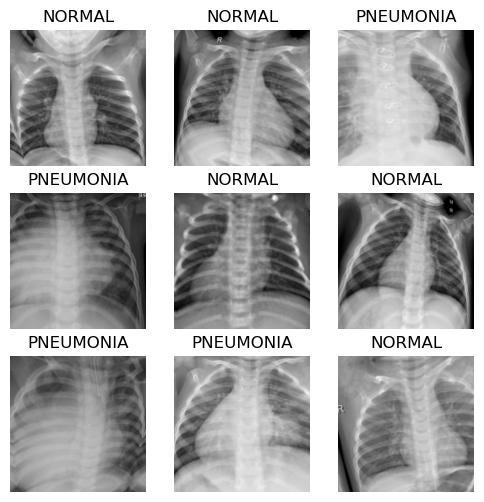

In [17]:
# Verify Data
dls.show_batch(max_n=9, figsize=(6, 6))

In [19]:
# Train using ResNet50
learn_resnet = cnn_learner(dls, resnet50, metrics=accuracy)
learn_resnet.fine_tune(5)  # Train for 5 epochs

C:\Users\HP\anaconda3\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:22<00:00, 4.54MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.390306,1.195027,0.666667,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.757839,0.937141,0.666667,00:11
1,0.606316,0.740475,0.666667,00:11
2,0.457426,0.572228,0.777778,00:11
3,0.379470,0.621608,0.666667,00:11
4,0.342845,0.675128,0.777778,00:12


In [27]:
# Calculate Accuracy for ResNet50
resnet_acc = learn_resnet.validate()[1]
print(f"ResNet50 Accuracy: {resnet_acc*100:.2f}%")

ResNet50 Accuracy: 77.78%


In [29]:
# Save ResNet50 Model
learn_resnet.export("pneumonia_resnet50.pkl")

In [31]:
# Train using EfficientNet
learn_efficient = cnn_learner(dls, efficientnet_b0, metrics=accuracy)
learn_efficient.fine_tune(5)  # Train for 5 epochs

C:\Users\HP\anaconda3\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
C:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\HP/.cache\to

epoch,train_loss,valid_loss,accuracy,time
0,1.772831,1.468124,0.555556,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.005586,1.124463,0.666667,00:06
1,0.801755,0.802614,0.666667,00:06
2,0.764593,0.719998,0.555556,00:05
3,0.584660,0.748750,0.666667,00:05
4,0.518877,0.858742,0.666667,00:05


In [35]:
# Calculate Accuracy for EfficientNet
efficient_acc = learn_efficient.validate()[1]
print(f"EfficientNet Accuracy: {efficient_acc*100:.2f}%")

EfficientNet Accuracy: 66.67%


In [37]:
# Save EfficientNet Model
learn_efficient.export("pneumonia_efficientnet.pkl")

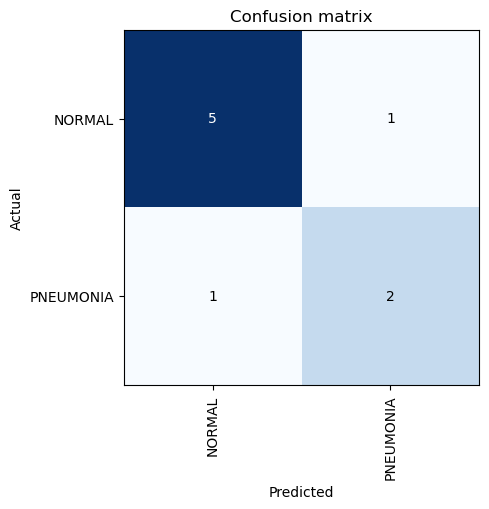

In [39]:
# Evaluate Model (Confusion Matrix)
interp = ClassificationInterpretation.from_learner(learn_resnet)
interp.plot_confusion_matrix(figsize=(5, 5))

In [71]:
# Prediction Function
def predict_image(img_path):
    img = PILImage.create(img_path)

    # Load ResNet50 Model & Predict
    learn = load_learner("pneumonia_resnet50.pkl")
    pred, pred_idx, probs = learn.predict(img)
    print(f"ResNet50 Prediction: {pred} ({probs[pred_idx]*100:.2f}%)")

    # Load EfficientNet Model & Predict
    learn_eff = load_learner("pneumonia_efficientnet.pkl")
    pred_eff, pred_idx_eff, probs_eff = learn_eff.predict(img)
    print(f"EfficientNet Prediction: {pred_eff} ({probs_eff[pred_idx_eff]*100:.2f}%)")

In [75]:
# Example Prediction
predict_image("Data/train/1.webp")  # Change path to an actual test image

ResNet50 Prediction: PNEUMONIA (65.16%)


EfficientNet Prediction: PNEUMONIA (92.03%)
